# Functions and imports

In [72]:
# Imports
from PIL import Image
import os, os.path
import numpy as np
import skimage

import matplotlib.pyplot as plt

#scikit-image ???
from skimage.measure import compare_ssim
from skimage.color import rgb2gray
from skimage.io import imread

print("Imports done")

#################################################

'''
diff_to_pos(gray1,gray2,th): movement
gray1, gray2: images compared (SSIM algo)
th: is the theshold of maximal likelihood (result of SSIM algo) between 0 and 1

return: probable movement position (mean) and variance of this estimation
'''

def diff_to_pos(gray1,gray2,th,fct="mean"):

    # compute ssim (struc sim)
    (score, sim) = compare_ssim(gray1, gray2, full=True)
    sim[sim>th] = 1 #discard little changes, if sim = 1 not diff between grp of pixels, if sim = 0 totally diff

    # reduce to 1D (column)
    col_mean = np.array(1 - sim).sum(0) # 1 - values to inverse and compute according to max of diff

    if col_mean.sum() == 0:
        return {"m": None,"v": None}

    else:
        if fct == "mean":
            col_mean /= max(col_mean)
            values = np.array([col_mean[i]*i for i in range(len(col_mean))])
            mean = values.sum() / col_mean.sum()

            values = np.array([abs(i-mean)*col_mean[i] for i in range(len(col_mean))])
            var = values.sum() / col_mean.sum()

        return {"m": round(mean,0),"v": var}

#################################################

'''
pos_to_move(pos1,pos2,th,width): movement
th: minimal movement (% of width) as positions and width are in pixel
return: -1 goes to the left, 1 to the right, 0 not enough changes (based on 2 consecutive movement positions: pos1 and pos2)
'''

def pos_to_move(pos1,pos2,th,width):
    ret = 0
    if (abs(pos1-pos2)/width > th):
        if (pos1 < pos2):
            ret = 1
        else:
            ret = -1
    return ret

#################################################

def thrd_filter(n,n1,n2,a,b):
    if n != None:
        n = n + a*(n1-n) + b*(n2-n)
        return n
    else:
        return n1

#################################################

def list_filter(values,a,b):
    init = False
    f2 = None
    f1 = None

    for i in range(len(values)):

        #initialize
        if not init:
            if values[i] != None and f2 == None:
                f2 = values[i]
            elif values[i] != None and f1 == None:
                f1 = values[i]

        else:
            values[i] = thrd_filter(values[i],f1,f2,a,b)
            f2 = f1
            f1 = values[i]

    return values

#################################################

'''
vid_to_movement(frames,move_th,sim_th): movements
frames: is a list of grayscaled frame (at least 3 images)
move_th: is a coefficient for the threshold dection of a minimal movement (if no movement, keep first position in memory)
sim_th: is a threshold for a maximal likelihood between pictures

return: {"moves": list_of_movements, "positions": {"m": mean, "v" variance}}

WARNING: at least 3 frames should be necessary to compute 2 frame diff and get one "movement"
    Thus for N pictures, it return N-2 "movement"
'''

def video_processing(frames,move_th,sim_th):

    if len(frames) > 3:
        frame_arr = np.array(frames)
        img_width = len(frames[0][0])
        
        pos_list = []
        for i in range(len(frames)-1):
            pos_list.append(diff_to_pos(frame_arr[i],frame_arr[i+1],sim_th))
        
        mv_list = []
        prev_pos = pos_list[0]['m']

        #get first pos
        static_i = 1
        while prev_pos == None and static_i < len(pos_list) - 1:
            prev_pos = pos_list[static_i]['m']
            mv_list.append(0)
            static_i += 1

        #compute "movement"
        for j in range(static_i, len(pos_list)):
            move = 0

            if (pos_list[j]['m'] != None):
                move = pos_to_move(prev_pos,pos_list[j]['m'],move_th,img_width)
                
                if (move != 0):
                    prev_pos = pos_list[j]['m'] #keep in memory new pos if enough "movement" between lastest images
            
            mv_list.append(move)
        
        return {"moves": mv_list, "positions": pos_list}

    else:
        return None
        
#################################################

print("OK")

Imports done
OK


# Recorded frames/video

### Extract a list of frame from video file or several pictures

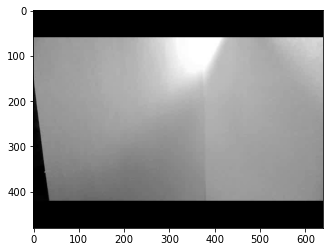

157 frames
 640.0 x 480.0 
FPS: 15.0
Settings saved


In [67]:
# Settings

video_format = True     #video should be mp4 format
# video_format = False    #pictures must be grayscaled

frames = []

if video_format: #case we use video file

    import cv2

    path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/records/"
    video_name = "test.mp4"
    full_path = path + video_name


    vidcap = cv2.VideoCapture(path + video_name) # open video

    # convert to list of frames
    success,image = vidcap.read()
    nbr_frame = 0
    while success:
        frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        success,image = vidcap.read()
        nbr_frame += 1

    if nbr_frame == 0:
        print("Cannot read video")
    else:
        framerate = vidcap.get(cv2.CAP_PROP_FPS)
        f_width = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)
        f_high = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        plt.imshow(frames[0], cmap='gray', vmin=0, vmax=255)
        plt.show()

        print(nbr_frame,"frames\n",f_width,"x",f_high,"\nFPS:",framerate)

else: #case we use multiple picture files
    path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/peipa/" #already PGM format for first video
    img_name = "hand-"
    img_format = ".pgm"
    full_path = path + img_name

    framerate = 24 #manual set(FPS)

    nbr_frame = len([name for name in os.listdir(path)]) #in case it's not a video file

    # Simulate video
    for i in range(nbr_frame-1):
        # WARNING must be greyscaled pictures
        #to grayscale : (may be diff between gray cv2 format and gray scikit format)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       #opencv
            #img_gray = rgb2gray(img)                               #scikit

        frames.append(imread(path + img_name + str(i+1) + img_format))

    f_width = len(frames[0][0])
    f_high = len(frames[0])

    plt.imshow(frames[0], cmap='gray', vmin=0, vmax=255)
    plt.show()

    print(nbr_frame,"frames\n",f_width,"x",f_high,"\nFPS:",framerate)

print("Settings saved")


### Processing part

[6.0, 22.0, 26.0, 23.0, 25.0, 20.0, 26.0, 27.0, 22.0, 20.0, 9.0, 12.0, 6.0, 2.0, None, None, 29.0, 19.0, None, 12.0, 30.0, 26.0, 21.0, 13.0, 28.0, 24.0, 23.0, 1.0, 19.0, 20.0, 22.0, 26.0, 27.0, 16.0, 15.0, 19.0, 25.0, 29.0, 40.0, 63.0, 85.0, 101.0, 102.0, 117.0, 132.0, 153.0, 173.0, 191.0, 211.0, 231.0, 230.0, 236.0, 282.0, 310.0, 351.0, 378.0, 424.0, 443.0, 474.0, 496.0, 501.0, 505.0, 494.0, 530.0, 523.0, 546.0, 488.0, 585.0, 457.0, 140.0, 44.0, 23.0, 71.0, 56.0, 49.0, 23.0, 26.0, 18.0, 14.0, 31.0, 146.0, 480.0, 589.0, 606.0, 577.0, 531.0, 468.0, 518.0, 516.0, 493.0, 477.0, 457.0, 461.0, 472.0, 481.0, 484.0, 477.0, 463.0, 446.0, 426.0, 409.0, 388.0, 368.0, 343.0, 319.0, 301.0, 282.0, 257.0, 241.0, 225.0, 196.0, 175.0, 154.0, 133.0, 108.0, 82.0, 52.0, 33.0, 25.0, 22.0, 39.0, 54.0, 54.0, 63.0, 71.0, 63.0, 67.0, 58.0, 50.0, 75.0, 128.0, 105.0, 55.0, 43.0, 44.0, 46.0, 50.0, 55.0, 59.0, 43.0, 46.0, 44.0, 42.0, 68.0, 62.0, 65.0, 67.0, 68.0, 63.0, 56.0, 70.0, 134.0, 121.0, 102.0, 71.0, 76.0]

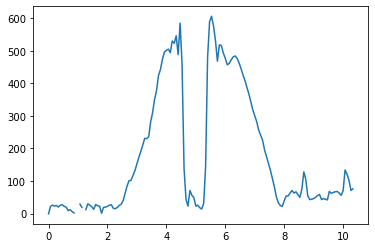

In [73]:
# processing on pictures included in the list "frames"

move_th = 0.001     # % of total width of the image (below this no mvt is detected)
sim_th = 0.4        #above this threshold, no changes are detected

alpha = 0.6
beta = 0.6

results = video_processing(frames,move_th,sim_th)
list_pos = list_filter([r["m"] for r in results["positions"]],alpha,beta)
# list_pos = [r["m"] for r in results["positions"]]

time = []
dt = 1/framerate
for f in range(len(list_pos)):
    time.append(round(f*dt,3))

# print(list_pos,"\n",time)

list_pos[list_pos==None]=-1
plt.plot(time,list_pos)

# Live record then process

Execute cell and press "q" to stop video record and start processing part.

[294.0, 291.0, None, 295.0, 260.0, None, 245.0, 222.0, None, 372.0, 222.0, 244.0, None, 260.0, 272.0, None, 284.0, 292.0, 296.0, 306.0, None, 319.0, None, 326.0, 338.0, None, 352.0, 367.0, 377.0, 386.0, None, 397.0, 413.0, None, 429.0, 442.0, None, 455.0, 398.0, 388.0, None, 435.0, None, 458.0, 453.0, 457.0, None, 477.0, 483.0, 509.0, 538.0, None, 513.0, 417.0, 318.0, None, 312.0] 
 [0.0, 0.10323691368103027, 0.15124034881591797, 0.19624114036560059, 0.24323797225952148, 0.29123973846435547, 0.33923912048339844, 0.3872396945953369, 0.4352426528930664, 0.48224377632141113, 0.5292484760284424, 0.5753388404846191, 0.6233606338500977, 0.6714165210723877, 0.7185399532318115, 0.7653162479400635, 0.8133077621459961, 0.8612704277038574, 0.9093461036682129, 0.9573173522949219, 1.0046436786651611, 1.0508222579956055, 1.0994977951049805, 1.1466343402862549, 1.1935513019561768, 1.2404937744140625, 1.2874960899353027, 1.3343191146850586, 1.3806114196777344, 1.427565336227417, 1.4736647605895996, 1.

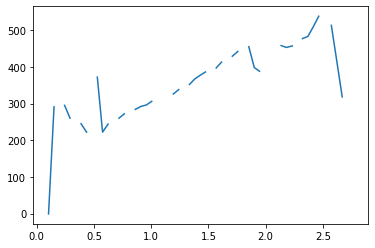

In [84]:
# Live cam

# Additional imports

import cv2
import time as t

# Settings

max_framerate = 25
dt = 1/max_framerate

move_th = 0.001     # % of total width of the image (below this no mvt is detected)
sim_th = 0.4        #above this threshold, no changes are detected

alpha = 0.6
beta = 0.6

# Init

cap = cv2.VideoCapture(0)

frames = []
start_t = t.time()
last_t = 0
time = []

while(True):

    if (t.time()-last_t) > dt:

        last_t = t.time()
        ret, frame = cap.read()

        ######## Code executed each frame
        time.append(last_t - start_t)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)

        cv2.imshow('frame',gray)
        ########

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

# Process and display

results = video_processing(frames,move_th,sim_th)
list_pos = list_filter([r["m"] for r in results["positions"]],alpha,beta)
# list_pos = [r["m"] for r in results["positions"]]

# print(list_pos,"\n",time)

list_pos[list_pos==None]=-1
plt.plot(time[1:len(time)],list_pos)

# Record video from Webcam

Execute cell and press "q" to stop video streaming and recording.

In [66]:
import cv2

video_path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/records/" #where the video is saved
video_name = "test.mp4"
grayscale = True
fps = 15.0

capture = cv2.VideoCapture(0) # find the webcam
w = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
h = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #record as mp4 format

if grayscale:
    video_writer = cv2.VideoWriter(video_path + video_name,fourcc, fps, (int(w),int(h)), 0)
else:
    video_writer = cv2.VideoWriter(video_path + video_name,fourcc, fps, (int(w),int(h)))

# record video
while (True):
    ret, frame = capture.read()
    if ret:
        if grayscale: frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        video_writer.write(frame)
        cv2.imshow('Video Stream', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
video_writer.release()
cv2.destroyAllWindows()

In [ ]:
# TODO and notes
'''
test with live

FPS too high -> not enough diff/disim between each frame to get nice result
'''